BLE生データからセル（ビーコンボロノイ）ごとにエネルギー状態を求める
timestepを20sec間隔に訂正
→その過程でod確定を行う

In [1]:
import pandas as pd 
import numpy as np 
import os 

In [2]:
basepath = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup' #/20230130_08' # /20230130_0845.csv'
day_stamp = '20230130'
time_stamp = '17'
date_stamp = f'{day_stamp}_{time_stamp}'
df = pd.read_csv(os.path.join(basepath, date_stamp, f'{date_stamp}45.csv'))
df_ble = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_nw_detail/ble_nw.csv')
df_node = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_stanw/ver0707/micro_node_post.csv')
df_link = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_stanw/ver0707/micro_link_post.csv')
df_matrix = pd.read_csv('/Users/takahiromatsunaga/res2023/shibuya_nw/shibuya_stanw/ver0707/nodebased_matrix_post.csv')

In [3]:
bleid_list = sorted(df['ID'].unique())
nodeid_list = sorted(df_node['nodeid'].unique())

10秒単位での検出macアドレス数→密度計算をプロット

In [64]:
# 平均以上のデータのみのこす
grouped = df.groupby('ID')
df_list = [group.reset_index(drop = True) for name, group in grouped]
filtered_df_list = []
mean_rssi_dict = {}
for j in range(len(df_list)):
    dfj = df_list[j]
    j_id = dfj.loc[0, 'ID']
    rssi_mean = dfj['RSSI'].mean()
    mean_rssi_dict[j_id] = rssi_mean

    filtered_dfj = dfj[dfj['RSSI'] >= rssi_mean]
    filtered_df_list.append(filtered_dfj)

print(mean_rssi_dict)

{1: -70.96875544601289, 2: -72.47366813150659, 3: -69.63541442411194, 4: -72.23674125940295, 5: -73.26723986223195, 6: -68.90700521106565, 7: -80.75457770890257, 15: -71.40985302014758, 16: -73.84083398898505, 17: -81.75435490568924, 18: -77.41459741856177, 19: -81.7093007393665, 20: -76.01519988391497, 21: -80.86591122092528, 22: -72.00792699594189, 23: -70.09121140142518}


In [65]:
resampled_df_list = []
for dfj in filtered_df_list:
    dfj_copy = dfj.copy()
    # print(dfj_copy)
    # dfj = filtered_df_list[j]
    dfj_copy['time'] = pd.to_datetime(dfj_copy['time'])
    dfj_copy.set_index('time', inplace=True)
    resampled_dfj = dfj_copy.groupby('ID').resample('10S')['MAC'].nunique().reset_index() # resample('10S')のところで10秒間隔でデータを再取得している！！
    resampled_df_list.append(resampled_dfj)
    # print(resampled_dfj) # resampleは10秒間のデータをまとめて（＝平均RSSIや検出MAC合計数など）10秒ごとに1行にしている

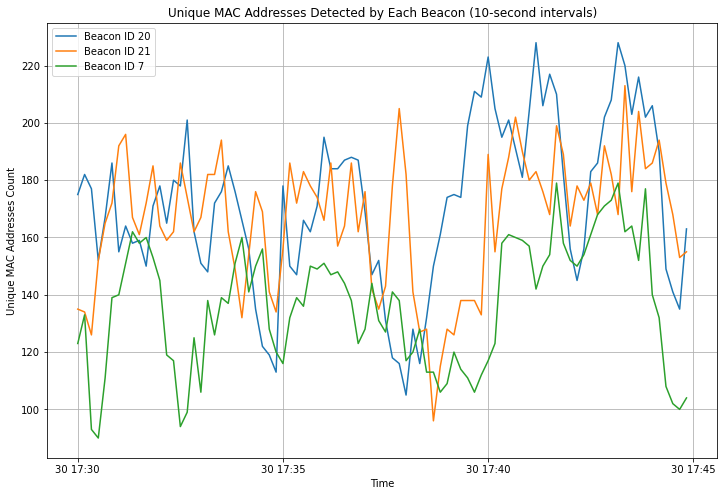

In [66]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))
for beacon_id in [20, 21, 7]:
    beacon_ix = bleid_list.index(beacon_id)
    # print(f'beaconid={beacon_id}, beacon_ix = {beacon_ix}')
    # beacon_data = resampled_df[resampled_df['ID'] == beacon_id]
    # print(beacon_data)
    # mean_rssi = mean_rssi_dict[beacon_id]
    # filterd_beacon_data = beacon_data[beacon_data['RSSI'] >= mean_rssi]
    dfjb = resampled_df_list[beacon_ix]
    plt.plot(dfjb['time'], dfjb['MAC'], label=f'Beacon ID {beacon_id}')

plt.xlabel('Time')
plt.ylabel('Unique MAC Addresses Count')
plt.title('Unique MAC Addresses Detected by Each Beacon (10-second intervals)')
plt.legend()
plt.grid(True)
plt.show()

各セルにおける主流の方向を判別する（これまでのコード内容とは別で実行可能）

In [4]:
# 個人ごとに分割
grouped2 = df.groupby('MAC')
df_list2 = [group.reset_index(drop = True) for name, group in grouped2]
print(len(df_list2))

47493


In [5]:
# 検出ビーコン数が2以下の場合消去
filtered_df_list2 = []
for u in range(len(df_list2)):
    dfu = df_list2[u]
    if dfu['ID'].nunique() <= 2:
        continue
    dfu_copy = dfu.copy()
    filtered_df_list2.append(dfu_copy)

print(len(filtered_df_list2)) # 23070くらい（半減した）

20396


20秒間隔でtimestep与えて絞り込む

In [6]:
# 10 or 20秒ごとにサンプリング
# 検出時間が3step以下のものは削除
import datetime 
import pytz
initial_time = pd.Timestamp(f'2023-01-30 {time_stamp}:30:00')
initial_time = initial_time.tz_localize('Asia/Tokyo')  # JSTとしてローカライズ
seconds = 20

#### dfu_copyにtime_diff列とtimestep列を付与
filtered_df_list3 = []
for dfu in filtered_df_list2:
    dfu_copy = dfu.copy()
    dfu_copy['time'] = pd.to_datetime(dfu_copy['time']).dt.tz_convert('Asia/Tokyo') 
    ## timeの昇順で並べ替えたい
    # dfu_copy = sorted.dfu_copy(key = 'time')
    
    # すでに形上では+9:00がついているものの，df.tz_convert以降をつけないと正式には認識されない！！
    dfu_copy['time_diff'] = (dfu_copy['time'] - initial_time).dt.total_seconds()
    dfu_copy['timestep'] = (dfu_copy['time_diff'] // seconds).astype(int) # dt.tz_localize('Asia/Tokyo') 
    
    dfu_copy = dfu_copy.sort_values(by='time').reset_index(drop=True)

    if dfu_copy['timestep'].nunique() <= 2:
        continue

    filtered_df_list3.append(dfu_copy)

print(len(filtered_df_list3))

19231


In [7]:
print(filtered_df_list3[0]) # 最初のuserのデータ，mac, id, rssi, time, time_diff, timestepのはず

    Unnamed: 0  ID                                                MAC  RSSI  \
0      2624654  22   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -76   
1      2624995  22   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -70   
2      2625338  22   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -71   
3      2625479  22   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -70   
4      2625627  22   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -81   
..         ...  ..                                                ...   ...   
85     1437516  21   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -84   
86      682624  20   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -74   
87      682793  20   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -82   
88      682936  20   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -71   
89      683410  20   0003f216d4a9dcea92f89c1fa8900206943b6558518f7...   -84   

                               time   time_diff  ti

各個人について20秒ごとにBLEビーコンNW上での観測重みグラフを作成
その差分から移動ベクトルを抽出したいが．．

In [8]:
res_dict = {} # 個人ごとに各timestepでBLEスコアを入れるT*Bのグラフ（行列）を格納
B = len(bleid_list) # Bはビーコン数
TT = int(900 / seconds) # 全部のtimestep数
print(f'seconds={seconds}, TT={TT}')
for dfi in filtered_df_list3: # 個人ごと
    res_mat = np.zeros((TT, B)) # 各timestepでの各ビーコンのスコア
    # 時間ごとに分けて集計
    grouped3 = dfi.groupby('timestep')
    mac = dfi.loc[0, 'MAC']
    dfit_list = [group.reset_index(drop = True) for name, group in grouped3]
    for dfit in dfit_list: # 各timestep内で
        ts = dfit.loc[0, 'timestep']
        # print(ts)
        it_dict = {} # 各ビーコンの累積スコアを記録する辞書
        for i in range(len(dfit)):
            beacon_id = dfit.loc[i, 'ID']
            beacon_ix = bleid_list.index(beacon_id)
            rssi = dfit.loc[i, 'RSSI']
            res_mat[ts-1, beacon_ix] += (100+rssi)/10
    res_dict[mac] = res_mat 

#### res_dictの要素数はfiltered_df_list3と同じ→iで回して同時に処理したい

# items1 = list(res_dict.items())
# # values = list(res_dict.values())
# print(items1[0])

seconds=20, TT=45


In [32]:
# # print(items1[0][1])
# # np.set_printoptions(threshold=np.inf)
# print(items1[0][0])
# indices = np.nonzero(items1[0][1])
# values = items1[0][1][indices]
# for index, value in zip(zip(*indices), values):
#     #print(index)
#     time_beacon = (index[0], bleid_list[index[1]])
#     print(f": time_beacon{time_beacon}, Value: {value}")


 00038a9bc1e248de3b9713d6967742fb8f85b24b7e7b4108bbacdc7a41366921
: time_beacon(40, 3), Value: 1.8
: time_beacon(40, 22), Value: 2.4
: time_beacon(42, 15), Value: 1.9
: time_beacon(42, 22), Value: 6.5
: time_beacon(43, 2), Value: 2.1
: time_beacon(43, 22), Value: 12.0
: time_beacon(44, 15), Value: 5.4
: time_beacon(45, 15), Value: 6.2
: time_beacon(45, 16), Value: 8.0
: time_beacon(46, 15), Value: 7.1000000000000005
: time_beacon(46, 16), Value: 4.4
: time_beacon(47, 16), Value: 2.5


res_dictに入っている個々人のスコア行列から時刻ごとの重心を出す

In [9]:
# res_matから重心を出す関数を定義
B = len(bleid_list)
ble_loc_mat = np.zeros((B, 3)) # ベクトルで持ってたほうが楽なはず
for i in range(B):
    bid = bleid_list[i] # ビーコンのid
    x, y, z = df_ble[df_ble['ID'] == bid]['x'].iloc[0], df_ble[df_ble['ID'] == bid]['y'].iloc[0], df_ble[df_ble['ID'] == bid]['floor'].iloc[0]
    ble_loc_mat[i, 0] = x
    ble_loc_mat[i, 1] = y
    ble_loc_mat[i, 2] = z

ble_x_vec = ble_loc_mat[:, 0]
ble_y_vec = ble_loc_mat[:, 1]
ble_z_vec = ble_loc_mat[:, 2]

x_tiled = np.tile(ble_x_vec, (TT, 1))
y_tiled = np.tile(ble_y_vec, (TT, 1))
z_tiled = np.tile(ble_z_vec, (TT, 1))


def gravity_center(res_mat): # res_matの形状はTT*B
    w_sum_vec = np.sum(res_mat, axis=1) # 重みの和
    w_sum_vec = (w_sum_vec==0) + (w_sum_vec!=0) * w_sum_vec
    xw_mat = res_mat * x_tiled
    yw_mat = res_mat * y_tiled
    zw_mat = res_mat * z_tiled
    x_center_vec = np.sum(xw_mat, axis=1) / w_sum_vec
    y_center_vec = np.sum(yw_mat, axis=1) / w_sum_vec
    z_center_vec = np.sum(zw_mat, axis=1) / w_sum_vec
    return x_center_vec, y_center_vec, z_center_vec

def interpolate_missing_values(vec): # 欠損部分（0）の補間を行う関数
    non_zero_indices = np.nonzero(vec)[0]
    zero_indices = np.where(vec == 0)[0]
    
    if len(non_zero_indices) == 0: # 非零成分がない場合は無視
        return vec  

    interpolated_vec = vec.copy()
    for zero_idx in zero_indices:
        # 前後の非零成分を見つける
        previous_non_zero_idx = non_zero_indices[non_zero_indices < zero_idx][-1] if len(non_zero_indices[non_zero_indices < zero_idx]) > 0 else None
        next_non_zero_idx = non_zero_indices[non_zero_indices > zero_idx][0] if len(non_zero_indices[non_zero_indices > zero_idx]) > 0 else None
        
        if previous_non_zero_idx is not None and next_non_zero_idx is not None:
            # 線形補間
            interpolated_value = vec[previous_non_zero_idx] + (vec[next_non_zero_idx] - vec[previous_non_zero_idx]) * (zero_idx - previous_non_zero_idx) / (next_non_zero_idx - previous_non_zero_idx)
            interpolated_vec[zero_idx] = interpolated_value

    return interpolated_vec

res_dict4 = {}

## 欠損観測間を補完
for mac, res_mat in list(res_dict.items()):
    x, y, z = gravity_center(res_mat) # ベクトル演算にしたのえらい
    x_corrected, y_corrected, z_corrected = interpolate_missing_values(x), interpolate_missing_values(y), interpolate_missing_values(z)
    res_dict4[mac] = [x_corrected, y_corrected, z_corrected]

#print(list(res_dict4.items())[0]) # 最初のuserのMACアドレス
# res_list = list(res_dict.items())[0][1]
# #print(res_list[0]) # xの座標
# print(list(res_dict.items())[0][1])

初期重心・最終重心に最寄りのノードから判定して一致するmacを抜き出す方が良い
＜本流とは外れるが00_seikeiの上位互換版＞
またこの時のodを記録しておく（ここでOD判定する）
→odlist_makeの役目はここで与えた方が楽である．odを確定させればいいので

In [10]:
homenodes = [i for i in range(1, 16)]
chuohachinodeds = [28, 29, 39] # ちょっと絞りすぎかもしれないが
saikyo_beacon = [19, 22, 23]
gatenodes = [df_node[df_node['floor'] != 20.5]]

In [41]:
gatenodes = df_node[df_node['floor'] != 20.5]['nodeid'].to_list()
print(gatenodes)


[24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 100]


In [26]:
from scipy.spatial import cKDTree

df_node_nonabs = df_node.copy()
df_node_nonabs = df_node_nonabs.iloc[:-1, :]
node_positions = df_node_nonabs[['x', 'y', 'floor']].values ### この書き方便利 # print(node_positions)
saikyo_nodelist = [i for i in range(1, 8)]
yamate_nodelist = [i for i in range(8, 16)]
# home_nodelist = [i for i in range(16, )]
df_node_saikyo = df_node_nonabs[df_node_nonabs['nodeid'].isin(saikyo_nodelist)]
df_node_yamate = df_node_nonabs[df_node_nonabs['nodeid'].isin(yamate_nodelist)]

node_positions_saikyo = df_node_saikyo[['x', 'y', 'floor']].values
node_positions_yamate = df_node_yamate[['x', 'y', 'floor']].values

kdtree = cKDTree(node_positions) # KDTreeを構築
kdtree_saikyo = cKDTree(node_positions_saikyo) # KDTreeを構築
kdtree_yamate = cKDTree(node_positions_yamate) # KDTreeを構築

### 途中の重心をどのノードに貼り付けるかのやつ
nonsaikyo_nodelist = [item for item in nodeid_list if item not in saikyo_nodelist]
nonyamate_nodelist = [item for item in nodeid_list if item not in yamate_nodelist]

df_node_nonsaikyo = df_node_nonabs[df_node_nonabs['nodeid'].isin(nonsaikyo_nodelist)] # ODが山手線の人用
df_node_nonyamate = df_node_nonabs[df_node_nonabs['nodeid'].isin(nonyamate_nodelist)] # ODが埼京線の人用

node_positions_nonsaikyo = df_node_nonsaikyo[['x', 'y', 'floor']].values
node_positions_nonyamate = df_node_nonyamate[['x', 'y', 'floor']].values

kdtree_nonsaikyo = cKDTree(node_positions_nonsaikyo) # KDTreeを構築
kdtree_nonyamate = cKDTree(node_positions_nonyamate) # KDTreeを構築

In [25]:
a = [1, 2, 3, 4, 5]
b = [2, 4]

c = [item for item in a if item not in b]
# c = [item if item not in b for item in a]

print(c)  # 結果: [1, 3, 5]

[1, 3, 5]


ODlist_makeをここで実装

In [17]:
# res4_dictにmacごとに重心座標ベクトルが入ってる
# res_dictにはビーコンスコアが入っている．res_dict, res_dict4, filtered_df_dict3は長さ同じ
# これまでに，各時刻のビーコンスコアと重心位置が算出されている
# odに応じて途中の重心のマッチングを変える

def is_continuous(lst):
    lst = sorted(lst)
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] != 1:
            return False
    return True

## 結果貼りつけ用
final_observation_df = pd.DataFrame(columns=['MAC', 'ID', 'RSSI', 'time', 'time_diff', 'timestep', 'tt', 'o', 'd'])

direction = 'on' # 後者の時 # direction = 'on' # 乗車の時

for i in range(len(res_dict)): # 個人毎
    mac, (x_grav, y_grav, z_grav) = list(res_dict4.items())[i] ## 個人の重心の時系列データ
    dfi = filtered_df_list3[i] # 個人のデータ
    dfi_timestep_list = dfi['timestep'].unique()
    
    ### ここで非連続なuserは切ってる→potential場を出す際にはきらない
    if not is_continuous(dfi_timestep_list):
        continue

    dfi['o'] = 0 # 初期値
    dfi['d'] = 0
    mac2, res_mat = list(res_dict.items())[i] # 各時間のビーコン毎のスコア
    #print('res_mat', res_mat)
    #print('observation_omit', np.nonzero(res_mat))

    ## この前に非観測時刻のものをスキップする必要 # 埼京ビーコンを判別するだけなのでres_matのうち0の行は排除するのでいいや
    new_res_mat = res_mat[~np.all(res_mat == 0, axis=1)]
    #print('new_res_mat', new_res_mat)
    new_x_grav = np.nonzero(x_grav) #[~np.all(x_grav == 0)] #, axis=1)]
    new_y_grav = np.nonzero(y_grav) # [~np.all(y_grav == 0)] #, axis=1)]
    new_z_grav = np.nonzero(z_grav) # [~np.all(z_grav == 0)] #, axis=1)]
    #print(f'x_grav={new_x_grav}, y_grav={new_y_grav}, z_grav={new_z_grav}')

    init_loc = np.array((x_grav[new_x_grav[0][0]], y_grav[new_y_grav[0][0]], z_grav[new_z_grav[0][0]]))
    last_loc = np.array((x_grav[new_x_grav[0][-1]], y_grav[new_y_grav[0][-1]], z_grav[new_z_grav[0][-1]]))

    dist_init, idx_init = kdtree.query(init_loc) # dist_tt, idx_tt = kdtree.query(pos_tt)
    dist_last, idx_last = kdtree.query(last_loc)

    nearest_inint_nodeid = df_node_nonabs.iloc[idx_init]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
    nearest_inint_nodeix = nodeid_list.index(nearest_inint_nodeid)
    nearest_last_nodeid = df_node_nonabs.iloc[idx_last]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
    nearest_last_nodeix = nodeid_list.index(nearest_last_nodeid)

    ## 埼京を判別してホーム区別
    max_beacons = np.argmax(new_res_mat, axis = 1) # resmatの各列でスコア最大のもののindexを取得
    max_beacons_list = max_beacons.tolist() # indexのリスト
    max_beacons_id_list = [bleid_list[item] for item in max_beacons_list] # indexをidに変換
    
    indicator = 'yamate' # 初期値はyamateにしておく

    if any(item in saikyo_beacon for item in max_beacons_id_list):
        indicator = 'saikyo'

    if direction == 'off':
        if nearest_inint_nodeid in homenodes and nearest_last_nodeid in chuohachinodeds:
            d_id = nearest_last_nodeid
            if indicator == 'saikyo':
                dist_init_, idx_init_ = kdtree_saikyo.query(init_loc) # dist_tt, idx_tt = kdtree.query(pos_tt)
                nearest_inint_nodeid_ = saikyo_nodelist[idx_init_]
            elif indicator == 'yamate':
                dist_init_, idx_init_ = kdtree_yamate.query(init_loc) # dist_tt, idx_tt = kdtree.query(pos_tt)
                nearest_inint_nodeid_ = yamate_nodelist[idx_init_]
                print(f'yamateある, init_idx={idx_init_}, init_nodeid={nearest_inint_nodeid_}') 
            
            o_id = nearest_inint_nodeid_ # homenodes_limitedから選ぶ
            print(f'o_id={o_id}')
        else:
            continue

    elif direction == 'on':
        if nearest_inint_nodeid in chuohachinodeds and nearest_last_nodeid in homenodes:
            o_id = nearest_inint_nodeid
            if indicator == 'saikyo':
                # print('tree_responce', kdtree_saikyo.query(last_loc))
                dist_last_, idx_last_ = kdtree_saikyo.query(last_loc) # dist_tt, idx_tt = kdtree.query(pos_tt)
                nearest_last_nodeid_ = saikyo_nodelist[idx_last_]
            elif indicator == 'yamate':
                dist_last_, idx_last_ = kdtree_yamate.query(last_loc) # dist_tt, idx_tt = kdtree.query(pos_tt)
                nearest_last_nodeid_ = yamate_nodelist[idx_last_]
                # print('tree_responce', kdtree_saikyo.query(last_loc))
            # nearest_last_nodeid_ = df_node_nonabs.iloc[idx_last_]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
            d_id = nearest_last_nodeid_ # homenodes_limitedから選ぶ            else:
        else:
            continue
    
    dfi['o'] = o_id
    dfi['d'] = d_id
    dfi['tt'] = 0

    init_timestep = dfi.loc[0, 'timestep']
    for i in range(len(dfi)):
        current_timestep = dfi.loc[i, 'timestep']
        dfi.loc[i, 'tt'] = current_timestep - init_timestep + 1
    last_tt = dfi.loc[len(dfi)-1, 'tt']

    if last_tt >= 16: # ちょっと長いのでカット
        continue

    columns_to_copy = ['MAC', 'ID', 'RSSI', 'time', 'time_diff', 'timestep', 'tt', 'o', 'd']
    dfi_columfiltered = dfi[columns_to_copy].copy()

    final_observation_df = pd.concat([dfi_columfiltered, final_observation_df], ignore_index=True)

####*****###------output------####****####
final_observation_df.to_csv(os.path.join(basepath, date_stamp, f'{date_stamp}45_{seconds}sec_{direction}.csv' ))

時系列重心座標の変化分とって移動ベクトル作る
（backup取っておいて助かった）

In [50]:
# 差分行列を計算する関数（tの重心とt+1の重心の差分がベクトル方向）
def compute_delta_matrix(res_mat):
    return res_mat[1:, :] - res_mat[:-1, :] 
def compute_delta_vac(res_vec):
    return res_vec[1:] - res_vec[:-1] 

# node_positions = df_node[['x', 'y', 'floor']].values ### この書き方便利 # print(node_positions)
# kdtree = cKDTree(node_positions) # KDTreeを構築

# 重心の移動ベクトルを各ノードにマッピングするための準備
node_vector_dict = {node_id: [] for node_id in df_node['nodeid'].values}
N = len(nodeid_list) - 1 # 吸収ノードを取り除いたノード数

# 集計的なポテンシャル場情報
potential_mat = np.zeros((TT, N, 5)) # 要素数，方向(0 or 1?)，速度3成分 # 

for i in range(len(res_dict)): # 個人毎
    mac, (x_grav, y_grav, z_grav) = list(res_dict4.items())[i] ## 個人の重心の時系列データ
    mac2, res_mat = list(res_dict.items())[i] # 各時間のビーコン毎のスコア

    new_res_mat = res_mat[~np.all(res_mat == 0, axis=1)]
    new_x_grav = np.nonzero(x_grav) #[~np.all(x_grav == 0)] #, axis=1)]
    new_y_grav = np.nonzero(y_grav) # [~np.all(y_grav == 0)] #, axis=1)]
    new_z_grav = np.nonzero(z_grav) # [~np.all(z_grav == 0)] #, axis=1)]
    #print(f'x_grav={new_x_grav}, y_grav={new_y_grav}, z_grav={new_z_grav}')

    init_loc = np.array((x_grav[new_x_grav[0][0]], y_grav[new_y_grav[0][0]], z_grav[new_z_grav[0][0]]))
    last_loc = np.array((x_grav[new_x_grav[0][-1]], y_grav[new_y_grav[0][-1]], z_grav[new_z_grav[0][-1]]))
    m_count = 0 # 観測時点のカウント数（観測があった時に+1）
    
    # print(type(init_loc))

    ### 速度計算部分 ### 
    vx_vec = compute_delta_vac(x_grav) # t=0-TTまでばーっと重心のx座標（欠損補完済み）が入っているベクトル
    vy_vec = compute_delta_vac(y_grav) 
    vz_vec = compute_delta_vac(z_grav)
    nonzero_indices = np.where(x_grav != 0)[0] 

    Ti = len(nonzero_indices)

    ## ホームと改札を移動している人は厳密にホームを判別する
    # if (init_loc in gatenodes and last_loc in homenodes) or (init_loc in homenodes and last_loc in gatenodes):
    if (np.any(np.isin(init_loc, gatenodes)) and np.any(np.isin(last_loc, homenodes))) or \
    (np.any(np.isin(init_loc, homenodes)) and np.any(np.isin(last_loc, gatenodes))):
        ## 埼京を判別してホーム区別
        max_beacons = np.argmax(new_res_mat, axis = 1) # resmatの各列でスコア最大のもののindexを取得
        max_beacons_list = max_beacons.tolist() # indexのリスト
        max_beacons_id_list = [bleid_list[item] for item in max_beacons_list] # indexをidに変換
        
        indicator = 'yamate' # 初期値はyamateにしておく

        if any(item in saikyo_beacon for item in max_beacons_id_list):
            indicator = 'saikyo'
        
        ## 最初と最後の観測は速度を0にする処理が必要
        for t in nonzero_indices-1: # 最後を抜く
            pos_t = np.array([x_grav[t], y_grav[t], z_grav[t]]) # 各時点での重心の位置

            m_count += 1
            if m_count == 1: # 最初の速度は座標分が入るので0にする
                continue

            else:
                if indicator == 'yamate':
                    dist_t, idx_t = kdtree_nonsaikyo.query(pos_t) # dist_tt, idx_tt = kdtree.query(pos_tt)
                    # nearest_node_id_t = df_node.iloc[idx_t]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                    nearest_node_id_t = nonsaikyo_nodelist[idx_t]
                    nearest_node_idx_t = nodeid_list.index(nearest_node_id_t)
                    # nearest_node_id_tt = df_node.iloc[idx_tt]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                    ### 間のノードをdijkstraでかき集めて，### とりあえずまずは始点だけにくっつけよう

                    potential_mat[t, nearest_node_idx_t, -3:] += np.array([vx_vec[t], vy_vec[t], vz_vec[t]])
                    potential_mat[t, nearest_node_idx_t, 0] += 1 # 最初の要素は数なので+1しておく

                elif indicator == 'saikyo':
                    dist_t, idx_t = kdtree_nonyamate.query(pos_t) # dist_tt, idx_tt = kdtree.query(pos_tt)
                    # nearest_node_id_t = df_node.iloc[idx_t]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                    nearest_node_id_t = nonyamate_nodelist[idx_t]
                    nearest_node_idx_t = nodeid_list.index(nearest_node_id_t)
                    # nearest_node_id_tt = df_node.iloc[idx_tt]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                    ### 間のノードをdijkstraでかき集めて，### とりあえずまずは始点だけにくっつけよう

                    potential_mat[t, nearest_node_idx_t, -3:] += np.array([vx_vec[t], vy_vec[t], vz_vec[t]])
                    potential_mat[t, nearest_node_idx_t, 0] += 1 # 最初の要素は数なので+1しておく

    ## ホーム-改札間の移動が不明瞭ならこれまで通り処理
    else:
        ## 最初と最後の観測は速度を0にする処理が必要
        for t in nonzero_indices-1: # 最後を抜く
            pos_t = np.array([x_grav[t], y_grav[t], z_grav[t]]) # 各時点での重心の位置

            m_count += 1
            if m_count == 1: # 最初の速度は座標分が入るので0にする
                continue

            else:
                dist_t, idx_t = kdtree.query(pos_t) # dist_tt, idx_tt = kdtree.query(pos_tt)
                # nearest_node_id_t = nonsaikyo_nodelist[idx_t]
                nearest_node_id_t = df_node.iloc[idx_t]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                # print(nearest_node_id_t)
                nearest_node_idx_t = nodeid_list.index(nearest_node_id_t)
                # nearest_node_id_tt = df_node.iloc[idx_tt]['nodeid'] # 時刻tの重心点と最寄りのノードidを返す
                ### 間のノードをdijkstraでかき集めて，### とりあえずまずは始点だけにくっつけよう

                potential_mat[t, nearest_node_idx_t, -3:] += np.array([vx_vec[t], vy_vec[t], vz_vec[t]])
                potential_mat[t, nearest_node_idx_t, 0] += 1 # 最初の要素は数なので+1しておく

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

In [49]:
# import numpy as np

# # サンプルデータ
# gatenodes = np.array([1, 3, 5])
# homenodes = np.array([2, 4, 6])

# # 複数の初期位置と最終位置の例
# init_loc = np.array([1])
# last_loc = np.array([7])

# # 条件判定
# if (np.any(np.isin(init_loc, gatenodes)) and np.any(np.isin(last_loc, homenodes))) or \
#    (np.any(np.isin(init_loc, homenodes)) and np.any(np.isin(last_loc, gatenodes))):
#     print("条件成立")
# else:
#     print("条件不成立")


条件不成立


大体大まかなものはできた．
速度を大きさにして数を太さにして向きを表現して3次元ノード&リンクのNW上で表現できそうか？？
それをやってみよう

In [52]:
# 全体での密度の最大値と速度の最大値で
dens_list = []
speed_list = []
for i in range(np.shape(potential_mat)[0]):
    max_dens = np.max(potential_mat[i, :, 0])
    # xv = potential_mat[i, :, -3]
    # yv = potential_mat[i, :, -2]
    # zv = potential_mat[i, :, -1]
    # # verocity = abs
    #if i == 1:
    velo_vec = potential_mat[i, :, -3:]
    speeds = np.linalg.norm(velo_vec, axis=1)  # 速度ベクトルの大きさ（速さ）を計算
    max_speed = np.max(speeds)
    #print(velo_vec)
    #print(speeds)
    #    break
    dens_list.append(max_dens)
    speed_list.append(max_speed)

maxx_dens = np.max(dens_list)
maxx_speed = np.max(speed_list)

print(maxx_dens)
print(maxx_speed)

839.0
5342.932248115056


時系列でベクトル場のグラフを描画

In [53]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
import imageio

# スケーリング係数を計算
# length_scale = 0.15 / maxx_speed if maxx_speed != 0 else 1
width_scale = 30 / maxx_dens if maxx_dens != 0 else 1
filenames = []

for t in range(TT):
    # if t == 4:
    # 時刻tのポテンシャル場
    potential_mat_t = potential_mat[t, :, :]  
    # グラフの作成
    G = nx.Graph()

    # 階ごとの配色の設定
    color_mapping = {
        14.8: 'orange',
        20.5: 'navy',
        28.5: 'orange' #'yellowgreen'
    }

    # ノードの追加
    for idx, row in df_node.iterrows():
        G.add_node(row['nodeid'], pos=(row['x'], row['y'], row['floor']))

    # リンクの追加
    for idx, row in df_link.iterrows():
        floor_source = G.nodes[row['o']]['pos'][2]  # リンクの始点の'floor'値
        floor_target = G.nodes[row['d']]['pos'][2]  # リンクの終点の'floor'値
        G.add_edge(row['o'], row['d'], linkid=row['linkid']) #, color = link_color) #, linewidth = link_width, linestyle = link_style)

    isolated_nodes = [node for node in G.nodes() if G.degree[node] == 0]

    # グラフからリンクを持たないノードを削除
    G.remove_nodes_from(isolated_nodes)

    # 座標の取得
    pos = nx.get_node_attributes(G, 'pos')

    # グラフの描画
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    # グリッドの設定
    ax.grid(True)

    # 各軸のメモリの間隔を10に設定
    ax.xaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_major_locator(MultipleLocator(40))
    ax.zaxis.set_major_locator(MultipleLocator(10))

    ####### ここからベクトルを追加する ########
    # 絶対値が長さ，向きはそのままベクトルの合成方向，太さがcount # ノードごとのベクトルを準備
    norm = plt.Normalize(0, maxx_speed)
    cmap = cm.cool 

    for i in range(np.shape(potential_mat)[1]): # 30のはず
        dens = potential_mat[t, i, 0]
        vector = potential_mat[t, i, -3:] # 速度ベクトル

        if dens > 0:  # 検出数が0より大きい場合のみプロット
            node_loc = np.array([df_node.loc[i, 'x'], df_node.loc[i, 'y'], df_node.loc[i, 'floor']])
            # length = np.linalg.norm(vector) * length_scale
            speed = np.linalg.norm(vector)
            color = cmap(norm(speed))

            # ベクトルの方向はそのまま、長さは1に正規化
            if speed != 0:
                vector = vector / speed

            ax.quiver(node_loc[0], node_loc[1], node_loc[2], 
                vector[0], vector[1], vector[2], 
                color = color, #cmap(color), 
                length = 20, 
                arrow_length_ratio = 0.15, linewidth = dens * width_scale
                )

    ax.view_init(elev=20, azim=60)  # elevは上下方向の角度、azimは左右方向の角度
    ax.set_box_aspect([1, 1, 0.5])  # [横方向, 前後方向, 上下方向]の比率を設定

    for node, coords in pos.items():
        ax.scatter(*coords, color='skyblue')

    for edge in G.edges(data=True):
        node1, node2, edge_attr = edge
        x = [pos[node1][0], pos[node2][0]]
        y = [pos[node1][1], pos[node2][1]]
        z = [pos[node1][2], pos[node2][2]]

        floor_source = G.nodes[node1]['pos'][2]  # リンクの始点の'floor'値
        floor_target = G.nodes[node2]['pos'][2]  # リンクの終点の'floor'値

        # 'floor'値に基づいて色を割り当てる
        if floor_source in color_mapping and floor_target in color_mapping:
            link_color = color_mapping[floor_source]  # 始点と終点の両方がマッピング内にある場合        
            link_width = 5.0   
            link_style = '-'   
        else: 
            link_width = 5.0
            link_color = 'lightgray'
            link_style = '--'   

        ax.plot(x, y, z, color=link_color, linewidth = link_width, linestyle = link_style)

    # plt.show()
        # 画像ファイルとして保存
    filename = f'timestep_{t + 1}_teisei.pdf'
    plt.savefig(os.path.join(f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{date_stamp}/potential_tempo', filename)) # os.path.join(basepath, date_stamp, filename))
    image_name = os.path.join(f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{date_stamp}/potential_tempo', filename)
    filenames.append(image_name)

    plt.close()

print("Images saved.")
output_dir = f'/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/{date_stamp}'
gif_filepath = os.path.join(output_dir, 'potential_animation_teisei.gif')

# 画像をGIFに変換
with imageio.get_writer(gif_filepath, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
# # 画像をGIFに変換
# with imageio.get_writer(gif_filepath, mode='I', duration=0.5) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

print("GIF created.")

Images saved.


ModuleNotFoundError: No module named '_gdal'

↑完了！！！！！


ここからはポテンシャルベクトル場をリンク説明変数として貼り付ける作業・・

In [63]:
## まずはノードの接続行列を作る
N = len(df_node) - 1 ## potential_matは吸収ノードを除いて定義されているので
nodeid_list = sorted(df_node['nodeid'].unique())
abs_id = 100           
abs_ix = nodeid_list.index(abs_id)

node_index_dict = {node_id: index for index, node_id in enumerate(nodeid_list)}
## pair_list作成 ##
pair_list = [
    (node_index_dict[df_matrix.loc[i, 'k']], node_index_dict[df_matrix.loc[i, 'a']])
    for i in range(len(df_matrix))]
for i in range(N): # 滞在リンク
    pair_list.append((i, i))
# pair_list.append((d_ix, abs_ix))

# ## I準備 ## 
# I = np.eye(N) # 滞在可能
# for i in range(len(df_matrix)):
#     kn = df_matrix.loc[i, 'k'] # node id
#     an = df_matrix.loc[i, 'a']
#     k = nodeid_list.index(kn) # node index
#     a = nodeid_list.index(an)
#     I[k, a] = 1 
# I[:, abs_ix] = 0
# I[abs_ix, :] = 0
# I[abs_ix, abs_ix] = 1

In [64]:
node_positions = df_node.set_index('nodeid')[['x', 'y', 'floor']].to_dict('index')
print(node_positions)

{1: {'x': -11893.836, 'y': -37943.567, 'floor': 20.5}, 2: {'x': -11903.914, 'y': -37920.992, 'floor': 20.5}, 3: {'x': -11915.067, 'y': -37897.88, 'floor': 20.5}, 4: {'x': -11924.07, 'y': -37873.692, 'floor': 20.5}, 5: {'x': -11932.939, 'y': -37848.161, 'floor': 20.5}, 6: {'x': -11939.912, 'y': -37822.54, 'floor': 20.5}, 7: {'x': -11944.726, 'y': -37799.509, 'floor': 20.5}, 8: {'x': -11894.159, 'y': -37984.022, 'floor': 20.5}, 9: {'x': -11907.157, 'y': -37960.855, 'floor': 20.5}, 10: {'x': -11919.01, 'y': -37937.833, 'floor': 20.5}, 11: {'x': -11929.337, 'y': -37914.03, 'floor': 20.5}, 12: {'x': -11935.886, 'y': -37891.361, 'floor': 20.5}, 13: {'x': -11946.591, 'y': -37869.573, 'floor': 20.5}, 14: {'x': -11952.259, 'y': -37845.392, 'floor': 20.5}, 15: {'x': -11955.768, 'y': -37823.842, 'floor': 20.5}, 24: {'x': -11934.054, 'y': -37842.541, 'floor': 14.8}, 25: {'x': -11935.62, 'y': -37825.393, 'floor': 14.8}, 26: {'x': -11958.599, 'y': -37829.136, 'floor': 14.8}, 27: {'x': -11963.427, 'y

In [65]:
print(np.shape(potential_mat))

(45, 30, 5)


In [67]:
len(nodeid_list)

31

In [68]:
N

30

In [75]:
### 滞在の場合は抵抗値0ね→OK
resistance_mat = np.zeros((TT, N, N))
for ka in pair_list:
    k, a = ka[0], ka[1] # k, aはindex
    k_id, a_id = nodeid_list[k], nodeid_list[a]
    start_pos = np.array([node_positions[k_id]['x'], node_positions[k_id]['y'], node_positions[k_id]['floor']])
    end_pos = np.array([node_positions[a_id]['x'], node_positions[a_id]['y'], node_positions[a_id]['floor']])
    link_direction = end_pos - start_pos
    link_direction_norm = link_direction / np.linalg.norm(link_direction)

    for t in range(TT):
        # ノードkの速度ベクトルを取得
        print(f't={t}, k={k}, a= {a}')
        v_vec = potential_mat[t, k, -3:]
        dens = potential_mat[t, k, 0]
        
        # 内積を計算して抵抗を定義
        dot_product = np.dot(v_vec, link_direction_norm) * dens / 10000
        resistance = np.tanh(dot_product) # tanhで変換
        # 1 / (1 + np.exp(-dot_product))  # シグモイド関数で変換
        print(f'dot={dot_product}, sigmoid={resistance}')
        # 抵抗を行列に保存
        resistance_mat[t, k, a] = resistance


t=0, k=0, a= 1
dot=-0.013686932794467864, sigmoid=-0.013686078191084259
t=1, k=0, a= 1
dot=-0.05204842883519707, sigmoid=-0.05200147930288555
t=2, k=0, a= 1
dot=0.009517517593317088, sigmoid=0.009517230228182775
t=3, k=0, a= 1
dot=-0.03354356315908368, sigmoid=-0.03353098807467552
t=4, k=0, a= 1
dot=-0.15723524798527488, sigmoid=-0.15595216347909477
t=5, k=0, a= 1
dot=0.005710256360898818, sigmoid=0.005710194296879183
t=6, k=0, a= 1
dot=0.24768465321254315, sigmoid=0.24274097102775777
t=7, k=0, a= 1
dot=0.7097170152149256, sigmoid=0.6104993498041653
t=8, k=0, a= 1
dot=0.26205518947664685, sigmoid=0.2562168139568285
t=9, k=0, a= 1
dot=-0.16699885182118168, sigmoid=-0.16546352120284596
t=10, k=0, a= 1
dot=0.11021206382277658, sigmoid=0.10976798375190772
t=11, k=0, a= 1
dot=1.2363577144567477, sigmoid=0.8444135941547786
t=12, k=0, a= 1
dot=3.361147119994051e-05, sigmoid=3.36114711872832e-05
t=13, k=0, a= 1
dot=0.19227549042422706, sigmoid=0.18994054711254146
t=14, k=0, a= 1
dot=-0.0636318

/var/folders/1p/_62pxgbn5kg837b06pfnvkdw0000gn/T/ipykernel_5876/233583798.py:9: RuntimeWarning: invalid value encountered in divide
  link_direction_norm = link_direction / np.linalg.norm(link_direction)



t=6, k=11, a= 11
dot=nan, sigmoid=nan
t=7, k=11, a= 11
dot=nan, sigmoid=nan
t=8, k=11, a= 11
dot=nan, sigmoid=nan
t=9, k=11, a= 11
dot=nan, sigmoid=nan
t=10, k=11, a= 11
dot=nan, sigmoid=nan
t=11, k=11, a= 11
dot=nan, sigmoid=nan
t=12, k=11, a= 11
dot=nan, sigmoid=nan
t=13, k=11, a= 11
dot=nan, sigmoid=nan
t=14, k=11, a= 11
dot=nan, sigmoid=nan
t=15, k=11, a= 11
dot=nan, sigmoid=nan
t=16, k=11, a= 11
dot=nan, sigmoid=nan
t=17, k=11, a= 11
dot=nan, sigmoid=nan
t=18, k=11, a= 11
dot=nan, sigmoid=nan
t=19, k=11, a= 11
dot=nan, sigmoid=nan
t=20, k=11, a= 11
dot=nan, sigmoid=nan
t=21, k=11, a= 11
dot=nan, sigmoid=nan
t=22, k=11, a= 11
dot=nan, sigmoid=nan
t=23, k=11, a= 11
dot=nan, sigmoid=nan
t=24, k=11, a= 11
dot=nan, sigmoid=nan
t=25, k=11, a= 11
dot=nan, sigmoid=nan
t=26, k=11, a= 11
dot=nan, sigmoid=nan
t=27, k=11, a= 11
dot=nan, sigmoid=nan
t=28, k=11, a= 11
dot=nan, sigmoid=nan
t=29, k=11, a= 11
dot=nan, sigmoid=nan
t=30, k=11, a= 11
dot=nan, sigmoid=nan
t=31, k=11, a= 11
dot=nan, s

In [76]:
import numpy as np
import pandas as pd

# 既存のコード...

# 抵抗行列をDataFrameに変換する関数
def resistance_matrix_to_dataframe(resistance_mat, nodeid_list):
    TT, N, _ = resistance_mat.shape
    data = []
    
    for t in range(TT):
        for k in range(N):
            for a in range(N):
                # if k != a:  # 滞在する場合は抵抗値0
                data.append([t, nodeid_list[k], nodeid_list[a], resistance_mat[t, k, a]])
    
    df = pd.DataFrame(data, columns=['time', 'node_k', 'node_a', 'resistance'])
    return df

# 抵抗行列をDataFrameに変換
resistance_df = resistance_matrix_to_dataframe(resistance_mat, nodeid_list)

# DataFrameをCSVとして保存
resistance_df.to_csv('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_17/resistance_matrix.csv', index=False)

print(f'Resistance data saved to resistance_matrix.csv')


Resistance data saved to resistance_matrix.csv


全ユーザの観測値を足してまとめて時系列可視化（あまり良くはなかった）

In [54]:
# 全ユーザの観測値を足し合わせる行列を初期化
total_res_mat = np.zeros((TT, B))

# 全ユーザの観測値を足し合わせる
for res_mat in res_dict.values():
    total_res_mat += res_mat

print(total_res_mat)

[[ 335.8 1923.4 2487.6 2724.5 2314.8 2299.9  926.2 1747.6  955.6  631.6
   797.4 1041.6 2191.8  901.3 1707.2 1771.3]
 [ 677.2 2650.6 2822.7 2532.3 2319.9 2959.9 1214.7 2367.  1195.4  783.7
   846.9 1391.3 2662.  1137.7 2399.2 2523.7]
 [ 762.5 2413.6 2750.7 2334.5 2023.7 3117.5 1205.8 2792.2 1719.4  769.8
   857.3 1255.9 2775.7 1366.2 2560.7 2783.6]
 [1108.8 2311.  2592.  2119.5 1936.9 3395.3 1117.5 2770.  1829.2  873.5
   811.3 1349.6 2618.6 1186.1 2076.  2558.6]
 [1178.6 2221.6 2451.8 2046.7 1838.7 3450.1 1092.1 2292.6 1689.1  809.9
   868.9 1580.1 2450.1 1261.6 1691.7 2569.3]
 [1019.3 2350.2 2215.3 2130.3 1777.  3440.1 1156.7 2382.9 1659.   717.6
   680.3 1222.4 2429.2 1294.5 1989.9 2292.4]
 [1041.4 2177.8 2275.  2488.  2300.2 3328.6 1408.3 2527.  1701.6  721.3
   726.3 1229.1 2509.1 1454.4 1940.7 2386.1]
 [1041.6 1937.4 2515.7 2038.9 1734.5 3293.8 1281.  3048.7 1843.   651.6
   727.9 1367.3 2418.1 1432.1 1853.1 2126.6]
 [ 851.1 2115.8 2089.5 1926.2 1509.  3179.7  960.5 3171.6 1741.5

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import imageio

# 色の範囲を設定
cmap = plt.get_cmap('cool')

# 保存する画像ファイルのリスト
filenames = []

# 各時刻のプロットを作成し、画像として保存
for t in range(TT):
    # fig = plt.figure()
    fig = plt.figure(figsize=(10, 8))  # 図のサイズを設定

    ax = fig.add_subplot(111, projection='3d')

    # スコアの大きさに応じて色を設定
    scores = total_res_mat[t, :]
    colors = cmap(scores / np.max(scores))  # スコアを正規化して色を設定

    # 3次元プロット
    sc = ax.scatter(ble_x_vec, ble_y_vec, ble_z_vec, c=colors, s=120, cmap='cool', marker='o')

    # カラーバーを追加
    plt.colorbar(sc)

    # 軸ラベルを設定
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Time Step {t + 1}')

    # 画像ファイルとして保存
    filename = f'timestep_{t + 1}.png'
    plt.savefig(os.path.join('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/temporary_image', filename)) # os.path.join(basepath, date_stamp, filename))
    image_name = os.path.join('/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08/temporary_image', filename)
    filenames.append(image_name)

    plt.close()

print("Images saved.")
output_dir = '/Users/takahiromatsunaga/res2023/bledata/ble_timegroup/20230130_08'
gif_filepath = os.path.join(output_dir, 'animation.gif')

# 画像をGIFに変換
with imageio.get_writer(gif_filepath, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF created.")


Images saved.
GIF created.


res_dictに入っている各mac address毎に時間TTと検出ビーコンBでのスコア行列がある．個人内で行列の上下の差分をとって変位行列を作成する


In [13]:
# delta_res_dict = {}
# for mac, res_mat in list(res_dict.items()):
#     # 各個人毎に
#     # print(len(list(res_dict.items())))
#     delta_mat = np.zeros((TT-1, B))
#     for t in range(TT-1):
#         delta_mat[t, :] = res_mat[t+1, :] - res_mat[t, :]
#     delta_res_dict[mac] = delta_mat

# items2 = list(delta_res_dict.items())
# print(items2[0][0])
# indices2 = np.nonzero(items2[0][1])
# values2 = items2[0][1][indices2]
# for index, value in zip(zip(*indices2), values2):
#     #print(index)
#     time_beacon = (index[0], bleid_list[index[1]])
#     print(f": time_beacon{time_beacon}, Value: {value}")


KeyboardInterrupt: 

ベクトル演算早すぎ＝＝＝＝＝

In [14]:
delta_res_dict = {}
# 差分行列を計算する関数
def compute_delta_matrix(res_mat):
    return res_mat[1:, :] - res_mat[:-1, :] # この書き方つよい

for mac, res_mat in res_dict.items():
    delta_res_dict[mac] = compute_delta_matrix(res_mat)

# for mac, res_mat in list(res_dict.items()):
#     # 各個人毎に
#     # print(len(list(res_dict.items())))
#     delta_mat = np.zeros((TT-1, B))
#     for t in range(TT-1):
#         delta_mat[t, :] = res_mat[t+1, :] - res_mat[t, :]
#     delta_res_dict[mac] = delta_mat

items2 = list(delta_res_dict.items())
print(items2[0][0])
indices2 = np.nonzero(items2[0][1])
values2 = items2[0][1][indices2]
for index, value in zip(zip(*indices2), values2):
    #print(index)
    time_beacon = (index[0], bleid_list[index[1]])
    print(f": time_beacon{time_beacon}, Value: {value}")


 00038a9bc1e248de3b9713d6967742fb8f85b24b7e7b4108bbacdc7a41366921
: time_beacon(39, 3), Value: 1.8
: time_beacon(39, 22), Value: 2.4
: time_beacon(40, 3), Value: -1.8
: time_beacon(40, 22), Value: -2.4
: time_beacon(41, 15), Value: 1.9
: time_beacon(41, 22), Value: 6.5
: time_beacon(42, 2), Value: 2.1
: time_beacon(42, 15), Value: -1.9
: time_beacon(42, 22), Value: 5.5
: time_beacon(43, 2), Value: -2.1
: time_beacon(43, 15), Value: 5.4
: time_beacon(43, 22), Value: -12.0
: time_beacon(44, 15), Value: 0.7999999999999998
: time_beacon(44, 16), Value: 8.0
: time_beacon(45, 15), Value: 0.9000000000000004
: time_beacon(45, 16), Value: -3.5999999999999996
: time_beacon(46, 15), Value: -7.1000000000000005
: time_beacon(46, 16), Value: -1.9000000000000004
: time_beacon(47, 16), Value: -2.5


重心の移動ベクトルから向きと速度を記憶し，これを最寄りのノード（セルorリンク）にマッピングする

In [ ]:
# とりあえず時間ごとの重心を出す


In [ ]:
# # import numpy as np
# import matplotlib.pyplot as plt
# from scipy.spatial import Voronoi, voronoi_plot_2d

# # データの例（各時刻における各個人の位置と移動ベクトル）
# positions = [np.array([...]), ...]  # 各時刻の位置データ
# velocities = [np.array([...]), ...]  # 各時刻の移動ベクトルデータ

# # ノードの位置
# nodes = np.array([...])  # ボロノイ図の中心ノードの位置

# # ボロノイ図の構築
# vor = Voronoi(nodes)
# voronoi_plot_2d(vor)
# plt.show()

# # セルごとの移動ベクトルの集計
# cell_vectors = {}
# for t, (pos, vel) in enumerate(zip(positions, velocities)):
#     for i, node in enumerate(nodes):
#         cell_vectors[i] = cell_vectors.get(i, []) + [vel[j] for j in range(len(pos)) if np.linalg.norm(pos[j] - node) < threshold]

# # 移動ベクトルの密度と向きの計算
# cell_density = {i: len(vectors) for i, vectors in cell_vectors.items()}
# cell_directions = {i: np.mean(vectors, axis=0) if vectors else np.zeros(2) for i, vectors in cell_vectors.items()}

# # ポテンシャル場の定義
# potential_field = {i: density * direction for i, (density, direction) in enumerate(zip(cell_density.values(), cell_directions.values()))}

# # 可視化
# for i, (density, direction) in potential_field.items():
#     plt.quiver(nodes[i, 0], nodes[i, 1], direction[0], direction[1], scale=density)
# plt.show()


In [67]:
# ## テスト
# import numpy as np

# def interpolate_missing_values(vec):
#     """
#     欠損部分（0）の補間を行う関数
#     """
#     non_zero_indices = np.nonzero(vec)[0]
#     zero_indices = np.where(vec == 0)[0]
    
#     if len(non_zero_indices) == 0:
#         return vec  # 全て0の場合はそのまま返す

#     interpolated_vec = vec.copy()
#     for zero_idx in zero_indices:
#         # 前後の非零成分を見つける
#         previous_non_zero_idx = non_zero_indices[non_zero_indices < zero_idx][-1] if len(non_zero_indices[non_zero_indices < zero_idx]) > 0 else None
#         next_non_zero_idx = non_zero_indices[non_zero_indices > zero_idx][0] if len(non_zero_indices[non_zero_indices > zero_idx]) > 0 else None
        
#         if previous_non_zero_idx is not None and next_non_zero_idx is not None:
#             # 線形補間
#             interpolated_value = vec[previous_non_zero_idx] + (vec[next_non_zero_idx] - vec[previous_non_zero_idx]) * (zero_idx - previous_non_zero_idx) / (next_non_zero_idx - previous_non_zero_idx)
#             interpolated_vec[zero_idx] = interpolated_value

#     return interpolated_vec

# # サンプルデータ
# xloc = np.array([
#       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
#       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
#       -11914.03528571, 0.0, 0.00, 0.0, 0, -11907.17570238, -11907.15497872, -11915.806, -11919.38515493, -11918.23671304, -11922.159, 
#       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
#       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
#       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# # 欠損部分の補間
# xloc_interpolated = interpolate_missing_values(xloc)

# print(xloc_interpolated)


[     0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
 -11914.03528571 -11912.66336904 -11911.29145238 -11909.91953571
 -11908.54761905 -11907.17570238 -11907.15497872 -11915.806
 -11919.38515493 -11918.23671304 -11922.159           0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.              0.              0.              0.
      0.            